In [20]:
%pip install --upgrade pip

%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [23]:
## Casey Data Preprocessing ##
df_train.head()
print(df_train['age_upon_intake'].unique())

# drop the rows with missing values in the 'age_upon_intake' column
df_train[df_train['age_upon_intake'].isna()]
df_train = df_train.dropna(subset=['age_upon_intake'])

df_train['sex_upon_intake'].unique()
df_train[df_train['sex_upon_intake'].isna()]['sex_upon_intake'] = 'Unknown'

# Function to convert age strings into years
def convert_age(age_str):
    # Expecting age_str in the format "<number> <unit>"
    # e.g., "2 years", "8 months", "3 weeks", "15 days"
    parts = age_str.split()
    if len(parts) != 2:
        return None
    try:
        num = float(parts[0])
    except ValueError:
        return None
    unit = parts[1].lower()
    if "year" in unit:
        return num
    elif "month" in unit:
        return num / 12
    elif "week" in unit:
        return num / 52
    elif "day" in unit:
        return num / 365
    else:
        return None

df_train['age_upon_intake'] = df_train['age_upon_intake'].apply(convert_age)

df_train[df_train['age_upon_intake'] < 0].head()



['8 years' '11 months' '2 years' '6 years' '6 months' '4 weeks' '5 months'
 '4 years' '1 month' '14 years' '2 weeks' '1 week' '2 months' '18 years'
 '9 years' '4 months' '1 day' '1 year' '3 years' '5 years' '8 months'
 '6 days' '7 years' '3 months' '12 years' '3 weeks' '9 months' '10 years'
 '10 months' '7 months' '0 years' '1 weeks' '5 days' '17 years' '2 days'
 '11 years' '4 days' '3 days' '15 years' '13 years' '5 weeks' '16 years'
 '19 years' '-1 years' '20 years' '-4 years' '22 years' nan '24 years']


/var/folders/yf/n0zzld6945vfyf6hj9_n1g4c0000gn/T/ipykernel_9651/116464133.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[df_train['sex_upon_intake'].isna()]['sex_upon_intake'] = 'Unknown'


,id,name,intake_time,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,outcome_time,date_of_birth,outcome_type
6828,A725472,Rascal,02/26/2019 11:25:00 AM,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,-1.0,Chihuahua Shorthair Mix,White/Brown,07/24/2016 03:54:00 PM,04/29/2020,Adoption
30959,A783723,Pina,11/05/2018 11:00:00 AM,3108 Crownover Street in Austin (TX),Stray,Normal,Cat,Intact Female,-4.0,Domestic Shorthair,White/Orange,11/12/2018 11:53:00 AM,02/07/2023,Adoption
44133,A797495,Ace,06/14/2019 11:34:00 AM,6814 East Riverside Drive in Austin (TX),Stray,Normal,Dog,Neutered Male,-1.0,Cairn Terrier,Black/Tan,06/17/2021 11:46:00 AM,12/16/2020,Transfer
70654,A753893,Chato,06/26/2015 04:30:00 PM,6709 Ponca Street in Austin (TX),Stray,Normal,Dog,Intact Male,-1.0,American Bulldog Mix,White/Brown,09/10/2017 12:00:00 AM,07/12/2016,Transfer


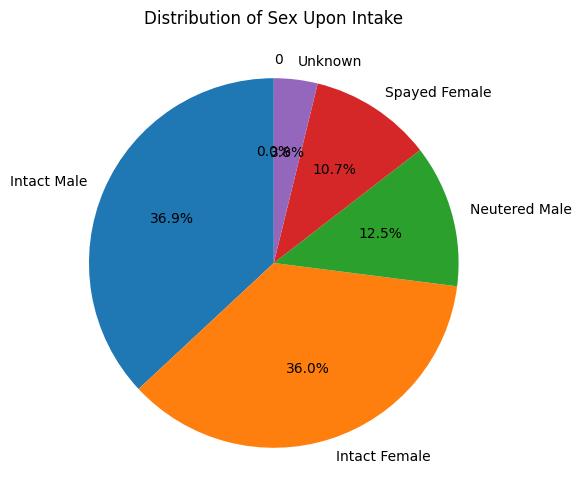

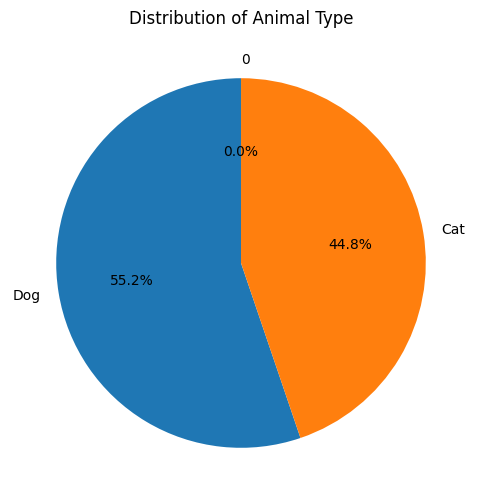

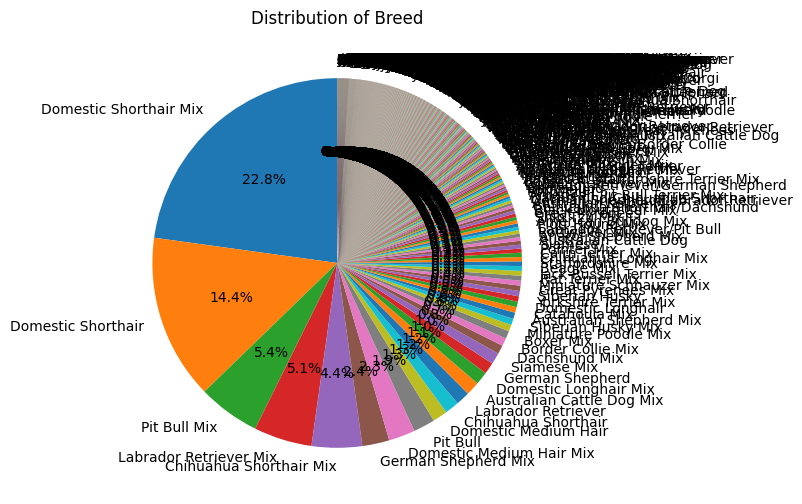

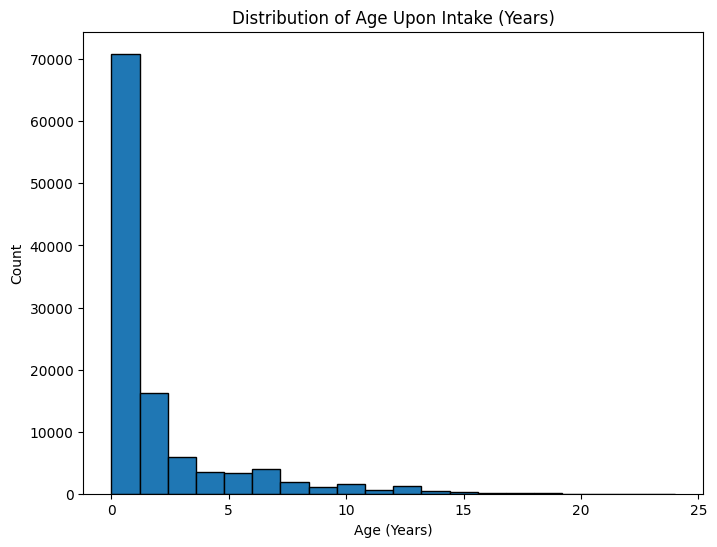

In [24]:
# set negative ages to 0
df_train[df_train['age_upon_intake'] < 0] = 0

# Pie chart for 'sex_upon_intake'
plt.figure(figsize=(6,6))
df_train['sex_upon_intake'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Sex Upon Intake")
plt.ylabel('')
plt.show()

# Pie chart for 'animal_type'
plt.figure(figsize=(6,6))
df_train['animal_type'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Animal Type")
plt.ylabel('')
plt.show()

# Pie chart for 'breed'
plt.figure(figsize=(6,6))
df_train['breed'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Breed")
plt.ylabel('')
plt.show()

# Bar chart (histogram) for 'age_in_years'
plt.figure(figsize=(8,6))
plt.hist(df_train['age_upon_intake'].dropna(), bins=20, edgecolor='black')
plt.title("Distribution of Age Upon Intake (Years)")
plt.xlabel("Age (Years)")
plt.ylabel("Count")
plt.show()

In [25]:
# Count the frequency of each breed
breed_counts = df_train['breed'].value_counts()

rare_breeds = breed_counts[breed_counts <= 3].index

# Filter the DataFrame for records with these rare breeds
rare_records = df_train[df_train['breed'].isin(rare_breeds)]

# Get the number of such records
rare_count = rare_records.shape[0]
print("Number of rare breeds:", rare_count)

Number of rare breeds: 2329


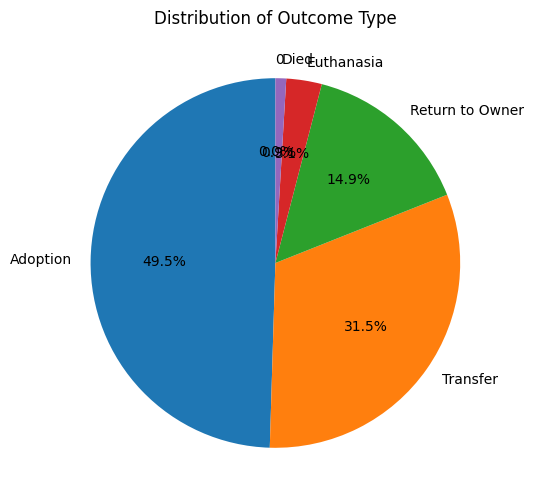

In [26]:
# Pie chart for 'outcome_type'
plt.figure(figsize=(6,6))
df_train['outcome_type'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Outcome Type")
plt.ylabel('')
plt.show()

In [27]:
df_train.describe()

,age_upon_intake
count,111156.000000
mean,1.906149
std,2.865817
min,0.000000
25%,0.083333
50%,1.000000
75%,2.000000
max,24.000000


In [28]:
## Data Preprocessing ##
'''
print('records with missing names:', df_train['name'].isna().sum())  

print('records that are blank or has numbers:', non_alpha_values.sum()) # does not wrok but you get the idea. fix pls
'''

"\nprint('records with missing names:', df_train['name'].isna().sum())  \n\nprint('records that are blank or has numbers:', non_alpha_values.sum()) # does not wrok but you get the idea. fix pls\n"

In [29]:
# Rebecca's slay data exploration block /ᐠ - ˕ -マ intake time, color, outcome time, date of birth

train_sample = df_train.sample(n=5000)

# feature engineering 

# calculating DAYS in shelter
train_sample["days_in_shelter"] = (pd.to_datetime(train_sample["outcome_time"]) - pd.to_datetime(train_sample["intake_time"])).dt.total_seconds() / 86400
# get rid of invalid rows
train_sample = train_sample.dropna(subset=["intake_time", "outcome_time"])
train_sample = train_sample[train_sample["intake_time"] < train_sample["outcome_time"]]

# calculating the primary color of the animal in both cats and dogs 
train_sample["primary_color"] = train_sample["color"].str.split("/, ").str[0]

# age group of cats


/var/folders/yf/n0zzld6945vfyf6hj9_n1g4c0000gn/T/ipykernel_9651/2740429093.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_sample["days_in_shelter"] = (pd.to_datetime(train_sample["outcome_time"]) - pd.to_datetime(train_sample["intake_time"])).dt.total_seconds() / 86400


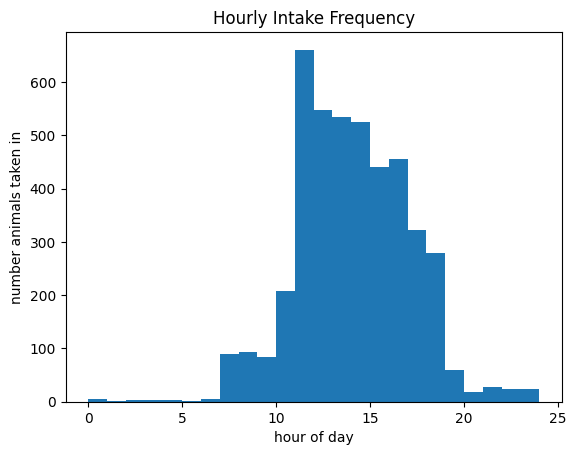

In [30]:
# what time of day are animals brought in? 
train_sample['intake_hour'] = pd.to_datetime(df_train['intake_time'], format="%m/%d/%Y %I:%M:%S %p", errors='coerce').dt.hour
plt.hist(train_sample["intake_hour"], bins=24, range=(0, 24))
plt.xlabel("hour of day")
plt.ylabel("number animals taken in")
plt.title("Hourly Intake Frequency") 
plt.show()

/var/folders/yf/n0zzld6945vfyf6hj9_n1g4c0000gn/T/ipykernel_9651/2410007291.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_sample["primary_color"] = cats_sample["primary_color"].apply(lambda x: x if x in top_colors else "Other")


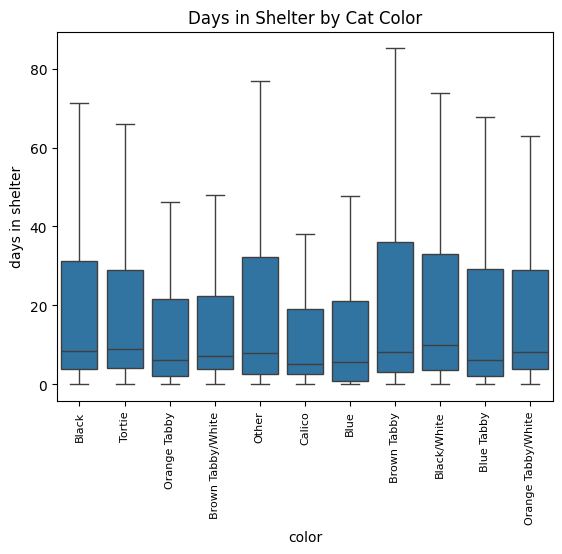

In [31]:
# CATS!
cats_sample = train_sample[train_sample["animal_type"] == "Cat"]

# narrow down to top colors for better visualization
top_colors = cats_sample["primary_color"].value_counts().nlargest(10).index
cats_sample["primary_color"] = cats_sample["primary_color"].apply(lambda x: x if x in top_colors else "Other")

# get rid of invalid ones 
cats_sample = cats_sample[cats_sample["days_in_shelter"] > 0]

# plot!
sns.boxplot(data=cats_sample, x="primary_color", y="days_in_shelter", showfliers=False)
plt.xlabel("color")
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("days in shelter")
plt.title("Days in Shelter by Cat Color")
plt.show()

/var/folders/yf/n0zzld6945vfyf6hj9_n1g4c0000gn/T/ipykernel_9651/2383781449.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dogs_sample["primary_color"] = dogs_sample["primary_color"].apply(lambda x: x if x in top_colors else "Other")


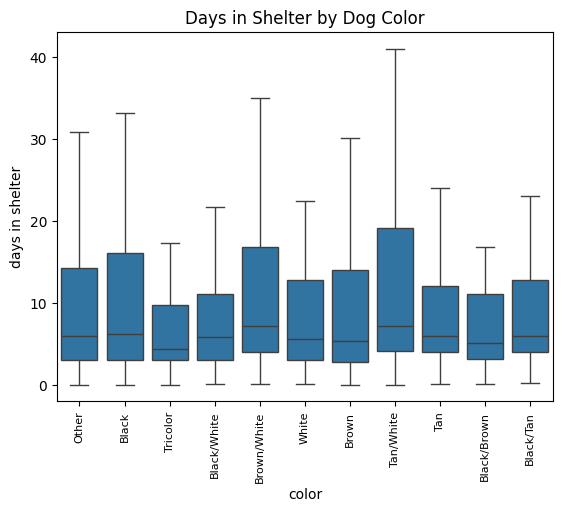

In [32]:
# dogs
dogs_sample = train_sample[train_sample["animal_type"] == "Dog"]

# only save top colors
top_colors = dogs_sample["primary_color"].value_counts().nlargest(10).index
dogs_sample["primary_color"] = dogs_sample["primary_color"].apply(lambda x: x if x in top_colors else "Other")

# getting rid of invalid ones 
dogs_sample = dogs_sample[dogs_sample["days_in_shelter"] > 0]

sns.boxplot(data=dogs_sample, x="primary_color", y="days_in_shelter", showfliers=False)
plt.xlabel("color")
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("days in shelter")
plt.title("Days in Shelter by Dog Color")
plt.show()

/var/folders/yf/n0zzld6945vfyf6hj9_n1g4c0000gn/T/ipykernel_9651/623366566.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adopted_cats["age_when_adopted"] = (pd.to_datetime(adopted_cats["outcome_time"]) - pd.to_datetime(adopted_cats["date_of_birth"])).dt.days / 365
/var/folders/yf/n0zzld6945vfyf6hj9_n1g4c0000gn/T/ipykernel_9651/623366566.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adopted_cats["age_group_when_adopted"] = adopted_cats["age_when_adopted"].apply(cat_age_groups)


([<matplotlib.patches.Wedge at 0x11c380ca0>,
 [Text(-0.9762707711333406, 0.5068484797557479, 'Kitten'),
  Text(0.9383423778594742, -0.5740327359245535, 'Adult'),
  Text(1.097294421607293, -0.07710351684272324, 'Senior')],
 [Text(-0.5325113297090948, 0.27646280713949883, '84.8%'),
  Text(0.5118231151960767, -0.31310876504975643, '13.0%'),
  Text(0.5985242299676143, -0.04205646373239449, '2.2%')])

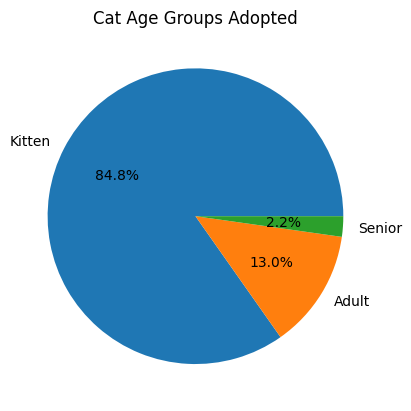

In [33]:
# cats adoptive sample
adopted_cats = cats_sample[cats_sample["outcome_type"] == "Adoption"]

# cat age groups
adopted_cats["age_when_adopted"] = (pd.to_datetime(adopted_cats["outcome_time"]) - pd.to_datetime(adopted_cats["date_of_birth"])).dt.days / 365

def cat_age_groups(age):
    if pd.isna("age"):  
        return "Unknown"
    elif age > 10:
        return "Senior"
    elif age > 2:
        return "Adult"
    return "Kitten"

adopted_cats["age_group_when_adopted"] = adopted_cats["age_when_adopted"].apply(cat_age_groups)

adopt_age_group_counts = adopted_cats["age_group_when_adopted"].value_counts()

plt.title("Cat Age Groups Adopted")
plt.pie(adopt_age_group_counts, labels=adopt_age_group_counts.index, autopct='%1.1f%%')

/var/folders/yf/n0zzld6945vfyf6hj9_n1g4c0000gn/T/ipykernel_9651/722849970.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  adopted_dogs["age_when_adopted"] = (pd.to_datetime(adopted_dogs["outcome_time"]) - pd.to_datetime(adopted_dogs["date_of_birth"])).dt.days / 365
/var/folders/yf/n0zzld6945vfyf6hj9_n1g4c0000gn/T/ipykernel_9651/722849970.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adopted_dogs["age_when_adopted"] = (pd.to_datetime(adopted_dogs["outcome_time"]) - pd.to_datetime(adopted_dogs["date_of_birth"])).dt.days / 365


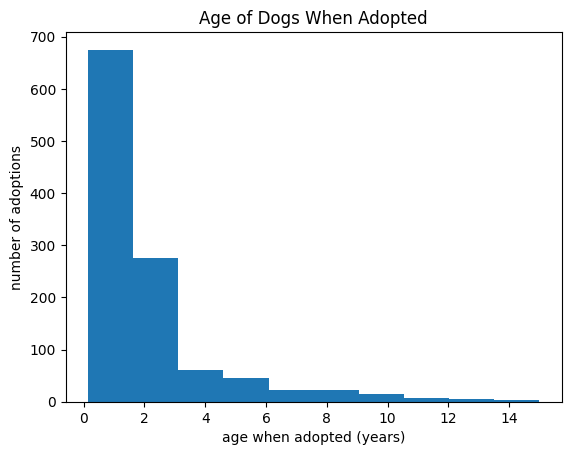

Text(0.5, 1.0, 'Age of Cats When Adopted')

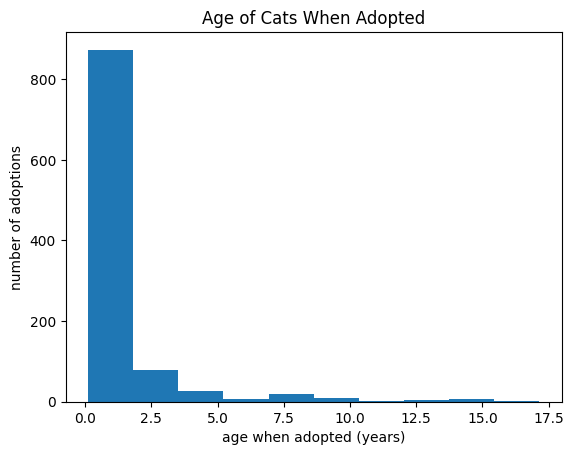

In [34]:
# age in MONTHS that are most popular for adoption - cats and dogs 
adopted_dogs = dogs_sample.dropna(subset="outcome_type")
adopted_dogs = dogs_sample[dogs_sample["outcome_type"] == "Adoption"]
adopted_dogs["age_when_adopted"] = (pd.to_datetime(adopted_dogs["outcome_time"]) - pd.to_datetime(adopted_dogs["date_of_birth"])).dt.days / 365

plt.hist(adopted_dogs["age_when_adopted"])
plt.xlabel("age when adopted (years)")
plt.ylabel("number of adoptions")
plt.title("Age of Dogs When Adopted")
plt.show()

plt.hist(adopted_cats["age_when_adopted"])
plt.xlabel("age when adopted (years)")
plt.ylabel("number of adoptions")
plt.title("Age of Cats When Adopted")

intake_type
Stray                 82159
Owner Surrender       21446
Public Assist          6131
Abandoned              1233
Euthanasia Request      182
0                         4
Wildlife                  1
Name: count, dtype: int64
0


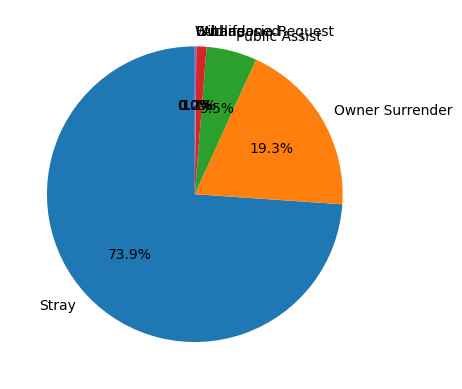

In [36]:
# Nneoma's data visualation

# I am going to look at the Intake Type

print(df_train['intake_type'].value_counts())
plt.pie(df_train['intake_type'].value_counts(), labels=df_train['intake_type'].value_counts().index, autopct='%1.1f%%', startangle=90)

print(df_train['intake_type'].isna().sum())

In [ ]:
df_cat = df_train[df_train['animal_type'] == 'Cat']
df_dog = df_train[df_train['animal_type'] == 'Dog']

In [ ]:
# Define custom color palettes
cat_colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
dog_colors = ['#c2c2f0','#ffb3e6','#c2f0c2','#f0c2c2']

# CAT INTAKE TYPES
print('CAT INTAKE TYPES')
print(df_cat['intake_type'].value_counts())
plt.figure(figsize=(6, 6))  # Optional: control pie size
plt.pie(df_cat['intake_type'].value_counts(), 
        labels=df_cat['intake_type'].value_counts().index, 
        autopct='%1.1f%%', 
        startangle=90,
        colors=cat_colors)
plt.title('Cat Intake Types')
plt.show()

print(df_cat['intake_type'].isna().sum())


# DOG INTAKE TYPES
print('DOG INTAKE TYPES')
print(df_dog['intake_type'].value_counts())
plt.figure(figsize=(6, 6))
plt.pie(df_dog['intake_type'].value_counts(), 
        labels=df_dog['intake_type'].value_counts().index, 
        autopct='%1.1f%%', 
        startangle=90,
        colors=dog_colors)
plt.title('Dog Intake Types')
plt.show()

print(df_dog['intake_type'].isna().sum())

In [ ]:
# INTAKE CONDITION

df_train['intake_condition'].unique() # 
print(df_train['intake_condition'].value_counts())
plt.pie(df_train['intake_condition'].value_counts(), labels=df_train['intake_condition'].value_counts().index, autopct='%1.1f%%', startangle=90)

print(df_train['intake_condition'].isna().sum())

In [ ]:
# SEGMENTED BY ANIMAL TYPE

# Define custom color palettes
cat_colors = ['#ffc0cb', '#ff9999', '#ffcccb', '#ffb6c1', '#e75480', '#ffa07a']
dog_colors = ['#add8e6', '#87ceeb', '#6495ed', '#4682b4', '#b0e0e6', '#5f9ea0']

# SEGMENTED BY ANIMAL TYPE

# CAT INTAKE CONDITION
print("CAT INTAKE CONDITIONS")
print(df_cat['intake_condition'].value_counts())
plt.figure(figsize=(6, 6))
plt.pie(df_cat['intake_condition'].value_counts(),
        labels=df_cat['intake_condition'].value_counts().index,
        autopct='%1.1f%%',
        startangle=90,
        colors=cat_colors)
plt.title('Cat Intake Condition')
plt.show()
print("Missing:", df_cat['intake_condition'].isna().sum())

# DOG INTAKE CONDITION
print("DOG INTAKE CONDITIONS")
print(df_dog['intake_condition'].value_counts())
plt.figure(figsize=(6, 6))
plt.pie(df_dog['intake_condition'].value_counts(),
        labels=df_dog['intake_condition'].value_counts().index,  # corrected this line!
        autopct='%1.1f%%',
        startangle=90,
        colors=dog_colors)
plt.title('Dog Intake Condition')
plt.show()
print("Missing:", df_dog['intake_condition'].isna().sum())

In [ ]:
#  Intake Type v Intake Condition

pd.crosstab(df_train['intake_type'], df_train['intake_condition'])

In [ ]:
# Found Location
# df_train.sample(50)

# number of rows that did NOT find the pet in Austin, TX
df_no_austin = df_train[~df_train['found_location'].str.contains('Austin', case=False, na=False)]
df_no_austin.shape[0]

# these are the rows that were found outside juridiction
df_outside = df_no_austin[df_no_austin['found_location'].str.contains('Outside')]
print('These are the Intake Types Among the Animals Found Outside Jurisdiction', df_outside['intake_type'].value_counts(), "\n")
print('These are the Intake Conditions Among the Animals Found Outside Jurisdiction', df_outside['intake_condition'].value_counts(), "\n")

pd.crosstab(df_outside['intake_type'], df_outside['intake_condition'])


# looking at the city names - will not keep city names
df_train['city_name'] = df_train['found_location'].str.split().str[-2:].apply(lambda x: ' '.join(x))
print('cities animals were found', df_train['city_name'].value_counts())
plt.pie(df_train['city_name'].value_counts(), labels=df_train['city_name'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.show()
pd.crosstab(df_train['city_name'], df_train['intake_type'])

In [ ]:
# MORE FOUND LOCATION (wanted to make it neater)
df_i35 = df_train[df_train['found_location'].str.contains(' 35 ')]
print('These are the Intake Types Among the Animals Found on the Interstate Hwy 35', df_i35['intake_type'].value_counts(), "\n")
print('These are the Intake Conditions Among the Animals on the Interstate Hwy 35', df_i35['intake_condition'].value_counts(), "\n")

In [ ]:
import re

def extract_street(location):
    if pd.isna(location):
        return None
    
    # Remove anything like "in Austin (TX)" or "Austin (TX)" at the end
    cleaned = re.sub(r'in Austin.*|Austin\s*\(TX\).*', '', location, flags=re.IGNORECASE).strip()
    
    # Remove leading numbers (e.g. "3522 " from "3522 East MLK Blvd")
    cleaned = re.sub(r'^\d+\s+', '', cleaned)
    
    return cleaned if cleaned else None



In [ ]:
df_train['street_name'] = df_train['found_location'].apply(extract_street)

# Set pandas options to display the entire content of each column
pd.set_option('display.max_colwidth', None)  # No truncation for strings
pd.set_option('display.max_rows', None)  # Show all rows (if not too many)


df_train['street_name'] = df_train['found_location'].apply(extract_street)
print(df_train['street_name'].value_counts())

In [ ]:
# Found Location by Highways
df_hwy = df_train[(df_train['found_location'].str.contains('evander', case=False, na=False)) | (df_train['found_location'].str.contains(' 35 ', case=False, na=False)) | (df_train['found_location'].str.contains('opac', case=False, na=False))]

print(df_hwy.shape[0])
print('These are the Intake Types Among the Animals Found on Highways', df_hwy['intake_type'].value_counts(), "\n")
print('These are the Intake Conditions Among the Animals on Highways', df_hwy['intake_condition'].value_counts(), "\n")

print("These are the number of Pets found on Street Corners")
df_train[(df_train['found_location'].str.contains('and', case=False, na=False)) | (df_train['found_location'].str.contains('&', case=False, na=False)) | (df_train['found_location'].str.contains('And', case=False, na=False))].shape[0]


In [ ]:

print("Number of Names with a * In It")
print(df_train[df_train['name'].str.contains(r'\*', na=False)].shape[0])


print('Number of Names with a Parentheses in It')
df_train[df_train['name'].str.contains(r'\(', na=False)]